# 주린이의 주가 예측

In [1]:
import pandas as pd
import numpy as np
import urllib.parse
import matplotlib.pyplot as plt
import matplotlib
from datetime import date, timedelta
import FinanceDataReader as fdr
from scipy import stats
import plotly.express as px
from selenium import webdriver
import bs4
%matplotlib inline

In [24]:
# 투자심리선이란 최근 2주(10일) 동안 주가가 전일과 대비해서 상승한 일수와 하락한 일수를 계산하여 
# 상승 일수가 며칠이었는가에 대한 비율을 나타낸다. 
# 투자심리도가 75% 이상이면 과열상태로 판단하여 매도시점이 되고,
# 반대로 25% 이하일 경우 매수시점이 된다.

In [25]:
# 안전하게 코스피 시가총액 상위 10위 종목만 선정

# 웹브라우저 설정 및 브라우저 팝업
options = webdriver.ChromeOptions()
# driverLoc = "C:/Users/김남덕/Desktop/KOPO/김효관/stddev/addon/chromedriver/chromedriver.exe"
driverLoc = "C:/Users/kopo/Desktop/KND/김효관/addon/chromedriver/chromedriver.exe"
driver = webdriver.Chrome(executable_path=driverLoc, options=options)

# 웹페이지 파싱될때까지 최대 3초 기다림
driver.implicitly_wait(3)

# 브라우저 열기
targetUrl = "https://finance.naver.com/sise/"
driver.get(targetUrl)

# 페이지 url 및 소스 가져오기
finalUrl = driver.current_url
pgSource = driver.page_source

# BS4로 웹크롤링
bsObj = bs4.BeautifulSoup(pgSource, "html.parser")
findAttr = bsObj.find(name = "table", attrs={"id":"siselist_tab_7"})
findPart = findAttr.find_all(name="a")

# 리스트에 종목 저장
stockNameList = []
for i in range(0, len(findPart)):
    stockNameList.append(findPart[i].text)

In [26]:
# 종목 코드 찾기
kospi = fdr.StockListing('kospi')

In [27]:
# 종료일
endDate = date.today()

# 시작일
beginDate = endDate - timedelta(days=90)

In [28]:
# 추출된 종목 코드를 리스트에 담기
stockCodeList = []
for i in range(len(stockNameList)):
    name = kospi[kospi['Name'] == stockNameList[i]]
    stockCode = name.iloc[0][0]
    stockCodeList.append(stockCode)

In [29]:
# 지난 3개월 동안의 주식 정보 가져오기
def getStockData(stockCode, beginDate, endDate):
    if stockCode is None:
        print("주식 코드 오류")
        return None
    dataFrame = fdr.DataReader(stockCode, beginDate, endDate)
    return dataFrame

In [30]:
def getStockNameByCode(code):
    symbol = kospi[kospi['Symbol'] == code]
    stockName = symbol.iloc[0][2]
    return stockName

In [31]:
def investLineMethod(df):
    changeList = [] # 변동률(Change) 리스트
    investLineList = [] # 투자 심리선 리스트
    tradingDays = 10 # 2주(10일) 기간 세팅
    for i in range(len(df)):
        changeList.append(list(df.Change[i-tradingDays:i])) # 투자 심리선 지표를 만들기 위해 2주(10일)간의 변동률(Change) 정보를 10개씩 리스트로 나눠 담는다
    for changeList2 in changeList: # 10개씩 담긴 리스트안에서 
        if not changeList2: # 만약 값이 없다면
            investLineList.append(0) # 0으로 채운다
        else:
            plusList = [] # 수익이 나온 일자를 저장할 리스트 생성
            for changeVal in changeList2: 
                if changeVal > 0: # 수익이 나왔다면 
                    plusList.append(changeVal) # 리스트에 저장
            plusVal = len(plusList) # 투자심리선 공식 = 10일동안 상승일 수 / 10일 * 100
            changeVal = len(changeList2)
            investLine = plusVal / changeVal * 100
            investLineList.append(investLine) # 투자 심리선에 저장
    df['investLine']=investLineList
    return df['investLine']

In [32]:
# matplotlib 한글 깨짐 방지
font_name = matplotlib.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name()
matplotlib.rc('font', family=font_name)

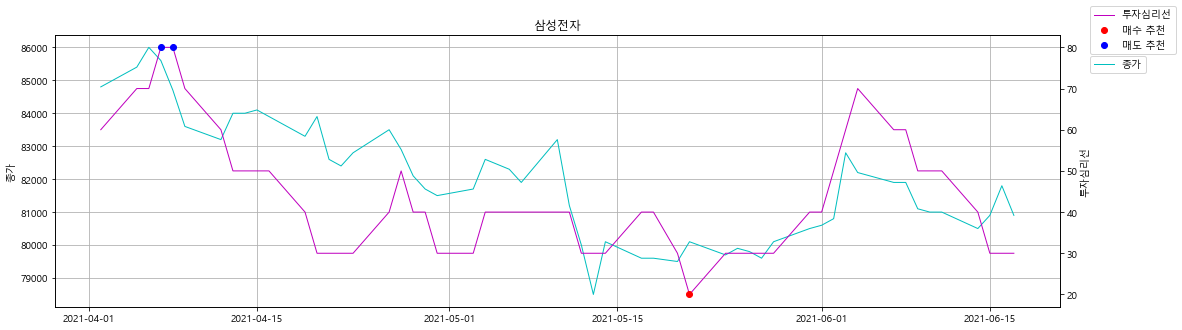

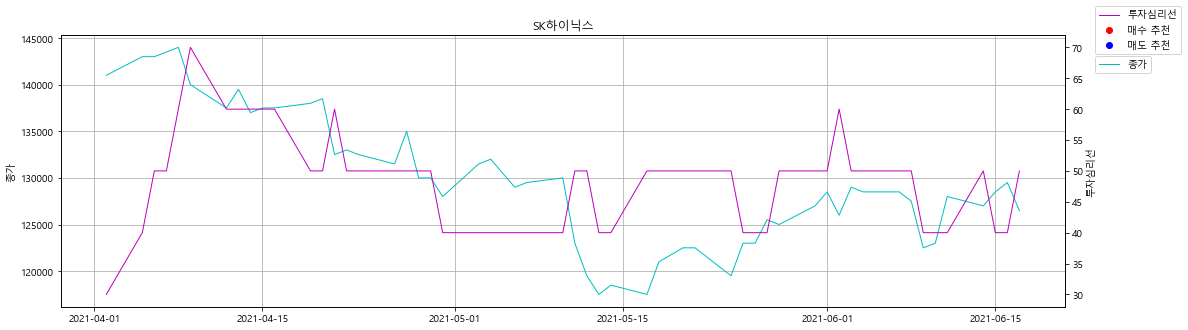

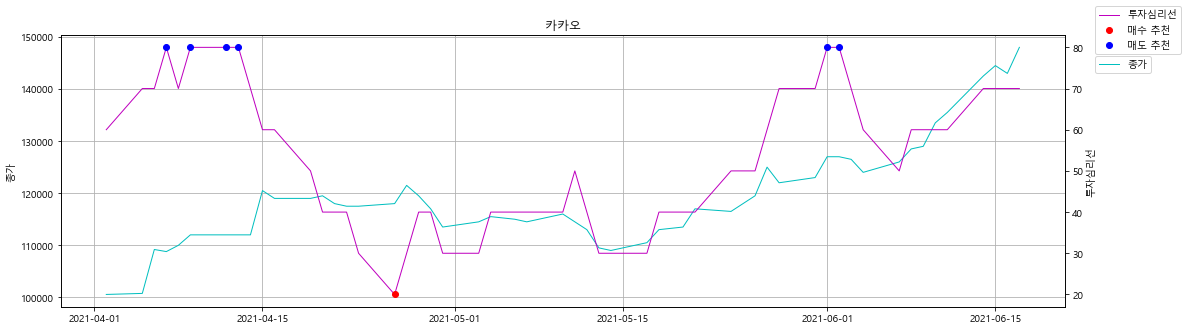

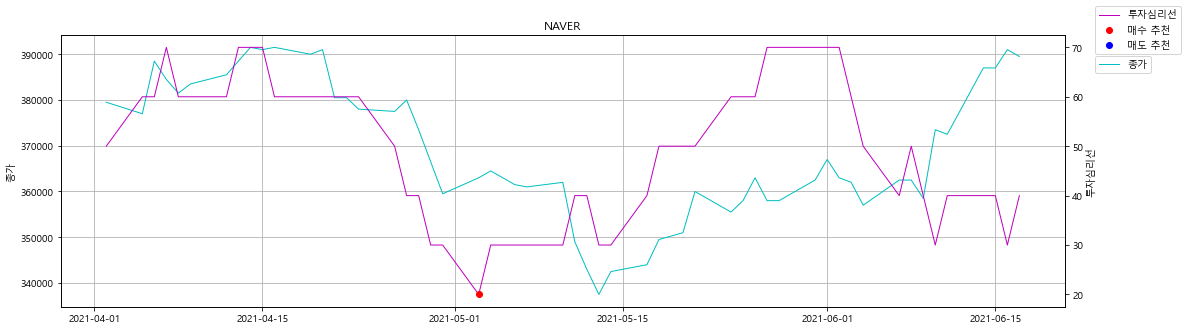

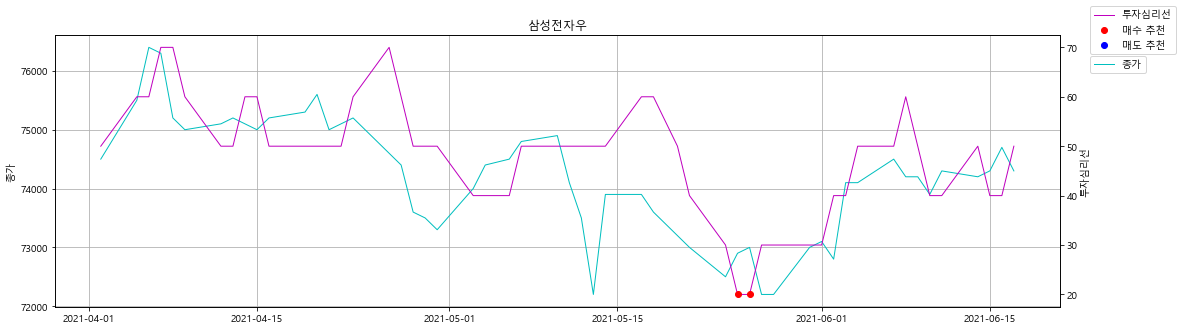

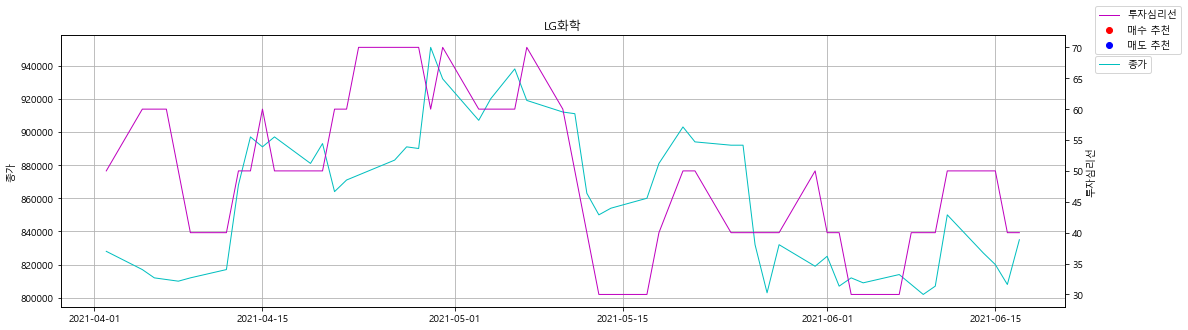

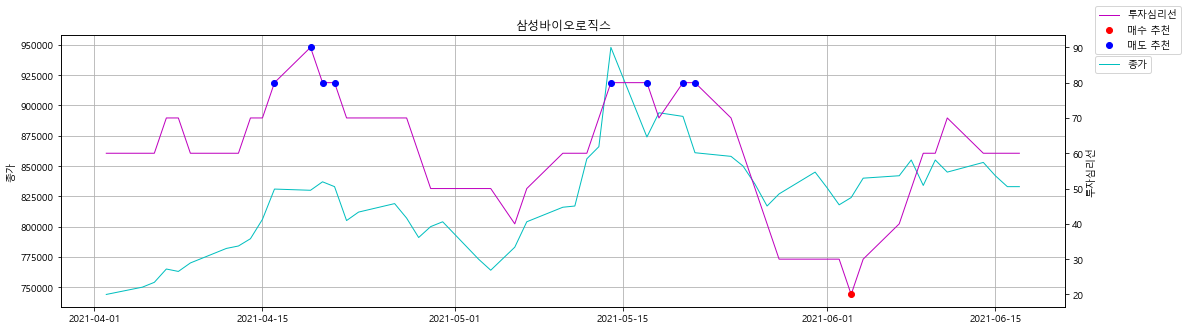

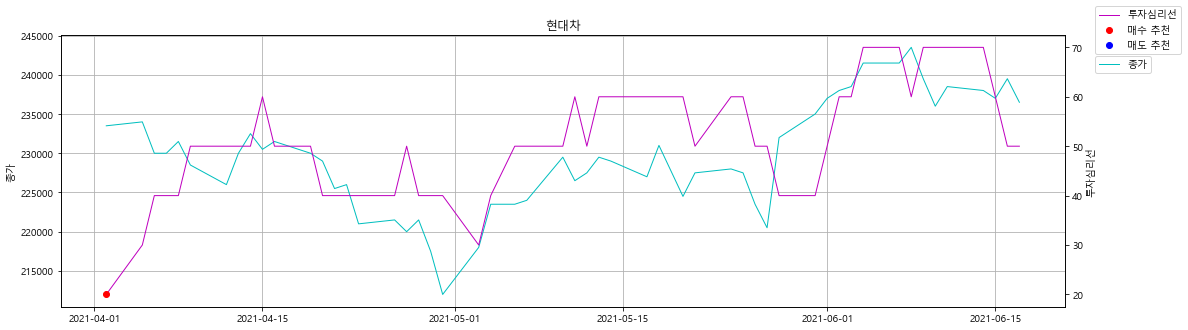

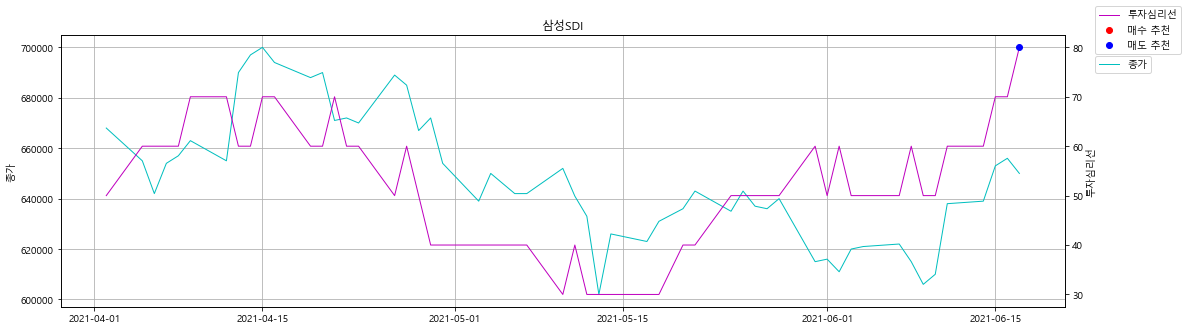

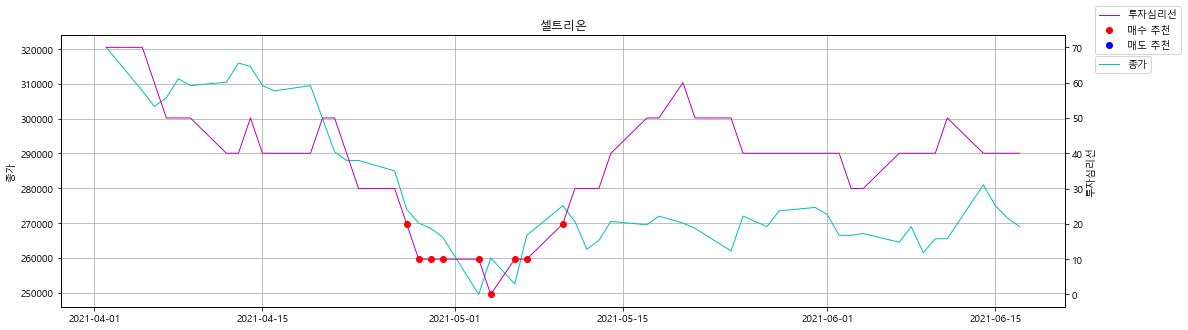

In [33]:
for code in stockCodeList:
    stockData = getStockData(code, beginDate, endDate)
    stockData.reset_index(inplace=True)
    result = investLineMethod(stockData)    
    exceptDays = 10
    x = stockData["Date"][exceptDays:]
    y = stockData["Close"][exceptDays:]
    y2 = result[exceptDays:]
    y3 = list(y2)
    y4 = list(y2)
    
    for i in range(len(y3)):
        if y3[i] >= 25.0:
            y3[i] = None
    for i in range(len(y4)):
        if y4[i] <= 75.0:
            y4[i] = None
            
    fig = plt.figure(figsize=(18,5))
    ax1 = fig.add_subplot(111)
    ax1.plot(x, y, 'c-', lw=1, label = '종가')
    ax1.grid(True)
    ax1.legend(loc=(1.03, 0.86))
    ax1.set_ylabel('종가')
    ax2 = ax1.twinx()
    ax2.plot(x,y2, 'm-', lw=1, label='투자심리선')
    ax2.plot(x,y3, 'o',color="r", lw=1, label='매수 추천')
    ax2.plot(x,y4, 'o',color="b", lw=1, label='매도 추천')
    ax2.legend(loc=(1.03, 0.93))
    ax2.set_ylabel('투자심리선')
    code2 = getStockNameByCode(code)
    plt.title(code2)
    plt.show()